In [1]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
FEATURES_LIST_FILE = "data/features"
RAW_DATA_CSV = "data/repro.csv"
BUILD_TAG = "BUILD"
REPRODUCTIBLE_TAG = "REPRO"

lines = None
with open(FEATURES_LIST_FILE, 'r') as stream:
    lines = map(lambda x: x.strip(), stream.readlines())

repro = pandas.read_csv(RAW_DATA_CSV)
repro_len = len(repro)
table = dict()

for elt in lines:
    table[elt] = [0 for _ in range(repro_len)]

table[BUILD_TAG] = list(repro["build?"])
table[REPRODUCTIBLE_TAG] = list(repro["reproducible?"])

for i in range(1, repro_len + 1):
    config = f"configs/{i:04d}_randconfig"
    with open(config, 'r') as stream:
        for line in stream:
            if line.startswith('#'):
                continue
            if line.startswith("CONFIG_"):
                name, value = line.strip().split('=')
                name = name[7:]
                table[name][i-1] = value

df = pandas.DataFrame.from_dict(table)

In [4]:
# We keep the columns where the values are not 'y' or 'm'.
# We drop the columns BUILD & REPRO since we need them
non_tristate = df.loc[:, ~(df.isin(['y', 'm'])).any()]\
               .drop(columns=[BUILD_TAG, REPRODUCTIBLE_TAG]).columns
df = df.drop(columns=non_tristate)

In [5]:
encoding_map = {
    'y': 1,
    'm': 2,
}
# Apply encoding
df = df.replace(encoding_map)

In [6]:
# Drop features that always have the same value
constant_columns = df.columns[df.nunique() == 1]
df = df.drop(constant_columns, axis=1)

In [9]:
# Separate the target variable and features
X = df.drop(columns=[REPRODUCTIBLE_TAG])
y = df[REPRODUCTIBLE_TAG]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train.shape, X_test.shape

((600, 988), (400, 988))

In [10]:
len(df.columns)

989

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy


1.0

In [12]:
from sklearn.tree import export_graphviz
import graphviz

ft_names = X_train.columns.tolist()

# Export the decision tree to DOT format
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ft_names, 
                           class_names=['Not Repro', 'Repro'], 
                           filled=True, rounded=True, 
                           special_characters=True)

# Render and save the visualization using graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree_repro", format="png")


'decision_tree_repro.png'

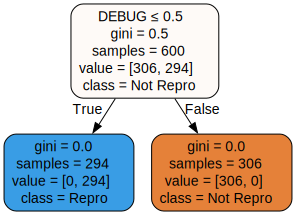

In [13]:
graph